In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow_addons

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import sklearn
import keras
import tensorflow_addons as tfa
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from tensorflow.keras.applications import *
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns               
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from time import time
import glob, warnings
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings('ignore')

In [4]:
traindf=pd.read_csv('/content/drive/MyDrive/dl_hackathon/train_(4).csv', dtype='str')
traindf.head()

,file_id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [46]:
traindf.shape

(1709, 2)

In [5]:
traindf['file_id'] = traindf['file_id'] + '.jpg'
traindf.head()

,file_id,label
0,0.jpg,0
1,1.jpg,0
2,2.jpg,0
3,3.jpg,0
4,4.jpg,0


In [6]:
count = traindf['label'].value_counts() 
print(count) 

1    949
0    760
Name: label, dtype: int64


In [7]:
train_path = '/content/drive/MyDrive/dl_hackathon/all'
test_path = '/content/drive/MyDrive/dl_hackathon/test'

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(traindf, test_size = 0.1, random_state = 42, stratify = traindf['label'])
print(train.shape)
print(test.shape)

(1538, 2)
(171, 2)


In [9]:
datagen_train = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
)


datagen_val = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

In [10]:
train_set = datagen_train.flow_from_dataframe(
    train,
    directory=train_path,
    seed=42,
    x_col='file_id',
    y_col="label",
    target_size = (300,300),
    class_mode='categorical',
    interpolation='nearest',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = 32,
)
test_set = datagen_val.flow_from_dataframe(
    test,
    directory=train_path,
    seed= 42,
    x_col='file_id',
    y_col="label",
    target_size = (300,300),
    color_mode = 'rgb',
    class_mode='categorical',
    interpolation='nearest',
    shuffle=False,
    batch_size= 32,    
)



Found 1538 validated image filenames belonging to 2 classes.
Found 171 validated image filenames belonging to 2 classes.


In [19]:
IMG_SIZE = 300
n_CLASS = 2

pretrained_model =    tf.keras.applications.efficientnet.EfficientNetB2(
            input_shape = (IMG_SIZE, IMG_SIZE, 3), 
            include_top = False,
            weights='imagenet',
            #drop_connect_rate=0.6,
        )
def create_model():
    
    model = Sequential()
    # initialize the model with input shape
    model.add(pretrained_model)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(
        256, 
        activation= tfa.activations.gelu,        
        bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)
    ))
    model.add(Dense(100, activation = tfa.activations.gelu))
    model.add(Dropout(0.4 , seed = 42))
    model.add(Dense(n_CLASS, activation = 'softmax'))
    
    return model
fake_model = create_model()

31801344/31790344 [==============================] - 1s 0us/step


In [20]:
fake_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 10, 10, 1408)      7768569   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1408)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               360704    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               25700     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

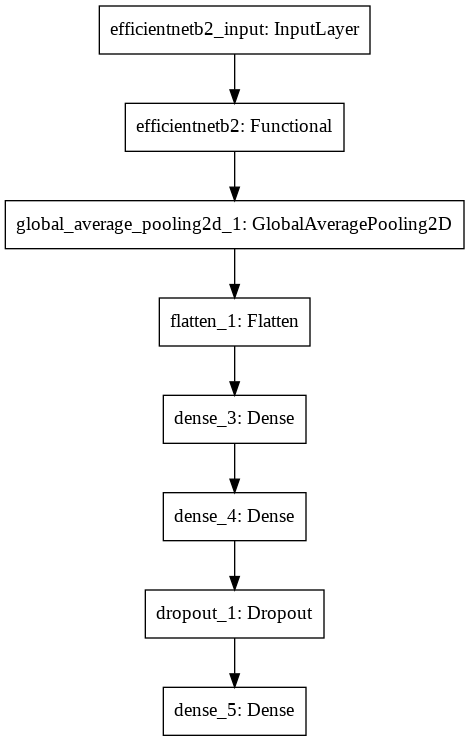

In [21]:
tf.keras.utils.plot_model(fake_model)

In [22]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

fake_model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(), 
              metrics = 'accuracy')


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 1,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-7,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath ='./fake1.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')


In [23]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time() - self.epoch_time_start)
        

time_callback = TimeHistory()

In [ ]:
int_epoch = 15
callbacks = [earlystopping, reduce_lr, checkpointer,time_callback] 
history = fake_model.fit(x = train_set,
          validation_data = test_set,
          epochs = int_epoch,
          callbacks = callbacks)    

In [25]:
 print("Not using Gradient Centralization:")    
print(f"Loss: {history.history['loss'][-1]}")         
print(f"accuracy: {history.history['accuracy'][-1]}")     
print(f"Validation accuracy: {history.history['val_accuracy'][-1]}") 
print(f"Training Time: {sum(time_callback.times)}")     

Not using Gradient Centralization:
Loss: 0.16467325389385223
accuracy: 0.9343302845954895
Validation accuracy: 0.8538011908531189
Training Time: 2129.4321615695953


In [26]:
acc = history.history['accuracy']
print(max(acc))

0.9343302845954895


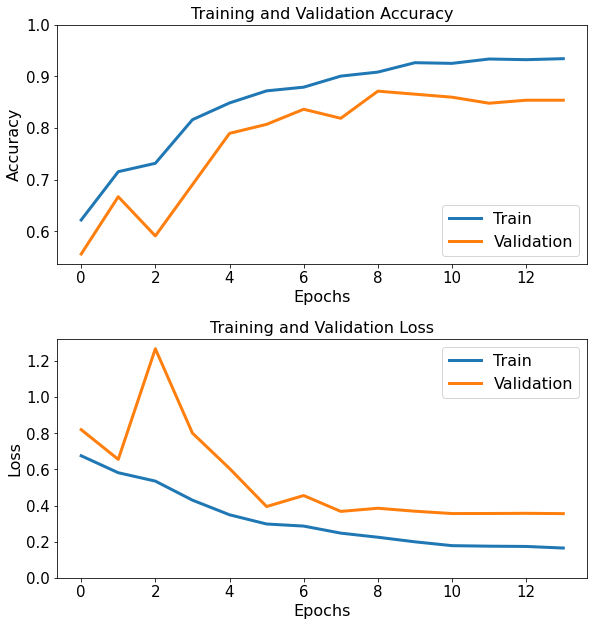

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss'] 


plt.figure(figsize=(9, 9)) 
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3.0)
plt.plot(acc, label='Train' , linewidth = 3)
plt.plot(val_acc, label='Validation', linewidth = 3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right' , prop={'size': 16})
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy' , fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy', fontsize=16)

plt.subplot(2, 1, 2)
plt.tight_layout(pad=3.0)
plt.plot(loss, label='Train', linewidth = 3)
plt.plot(val_loss, label='Validation', linewidth = 3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', prop={'size': 16})
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

In [28]:
def load_trained_model(weights_path):
   model = create_model()
   model.load_weights(weights_path)
   return model

In [30]:
new_model = load_trained_model('fake1.hdf5')
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 10, 10, 1408)      7768569   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1408)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               360704    
_________________________________________________________________
dense_10 (Dense)             (None, 100)               25700     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

In [35]:
testdf=pd.read_csv('/content/drive/MyDrive/dl_hackathon/test_(3).csv', dtype='str')
testdf.head()

,file_id
0,0
1,1
2,2
3,3
4,4


In [37]:
testdf['file_id'] = testdf['file_id'] + '.jpg'
testdf.head()

,file_id
0,0.jpg
1,1.jpg
2,2.jpg
3,3.jpg
4,4.jpg


In [38]:
datagen_test = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

In [42]:
main_test = datagen_val.flow_from_dataframe(
    testdf,
    directory=test_path,
    seed= 42,
    x_col='file_id',
    y_col = None,
    target_size = (300,300),
    color_mode = 'rgb',
    class_mode=None,
    interpolation='nearest',
    shuffle=False,
    batch_size= 32,    
)

Found 332 validated image filenames.


In [43]:
y_pred = new_model.predict(main_test)

In [45]:
y_predargmax = tf.argmax(y_pred , 1)
print(y_predargmax)

tf.Tensor(
[0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 1
 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0
 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(332,), dtype=int64)


In [48]:
final_test = pd.read_csv('/content/drive/MyDrive/dl_hackathon/test_(3).csv', dtype='str')
final_test.head()

,file_id
0,0
1,1
2,2
3,3
4,4


In [49]:
final_test['label'] = y_predargmax

In [50]:
final_test.head()

,file_id,label
0,0,0
1,1,0
2,2,1
3,3,1
4,4,0


In [51]:
final_test.to_csv('submission.csv', index=False)